In [3]:
using Pkg
Pkg.instantiate()
Pkg.add("MCMCChains")
using TAMode
using LinearAlgebra

  Resolving package versions...
   Updating `~/TAMode.jl/Project.toml`
 [no changes]
   Updating `~/TAMode.jl/Manifest.toml`
 [no changes]


In [4]:
using MCMCChains
chn = read("chain-file-6_26.jls", Chains)
summarize(chn)

Summary Statistics
     parameters     mean     std  naive_se    mcse      ess   r_hat
  ─────────────  ───────  ──────  ────────  ──────  ───────  ──────
        AXLexpr  24.4652  1.7037    0.1078  0.6163   7.8061  1.1169
         Ig2rev   0.1308  0.1487    0.0094  0.0749   5.4740  1.1725
         gasCur   0.2270  0.2220    0.0140  0.1124   5.3856  1.1841
    internalize   0.0453  0.0114    0.0007  0.0048   7.2654  1.1545
           kDeg   0.0235  0.0072    0.0005  0.0045   4.9615  1.2561
           kRec   0.0900  0.0580    0.0037  0.0296   5.8971  1.1813
  pYinternalize   1.0769  0.1129    0.0071  0.0348  15.5465  1.0517
          scale   0.0302  0.0115    0.0007  0.0071   4.7714  1.2904
      scaleSurf   0.0002  0.0002    0.0000  0.0001   5.3632  1.1732
          sortF   0.2971  0.0234    0.0015  0.0117   3.8863  1.5341
           xFwd   0.0011  0.0039    0.0002  0.0014   5.9949  1.0791


In [16]:
Ig2rev = get(chn, :Ig2rev)[1]
scale = get(chn, :scale)[1]
scaleSurf = get(chn, :scaleSurf)[1]

x = get(chn, [:internalize, :pYinternalize, :sortF, :kRec, :kDeg, :xFwd, :gasCur, :AXLexpr]);
samp_params = hcat(x.internalize, x.pYinternalize, x.sortF, x.kRec, x.kDeg, x.xFwd, x.gasCur);

In [17]:
tps = range(0.0, 1440, length=200)
index = 201
# M0
AXLexpr = 6.0
MerTKexpr = 0.0
Tyro3expr = 5.0
params = vcat(samp_params[index, :], AXLexpr, MerTKexpr, Tyro3expr, Ig2rev[index], [1.0, 1.0, 1.8, 100.0]);
print(tps[1])

0.0

In [18]:
pYAXL = TAMode.pY .* TAMode.recpSpecific[1]
surfAXL = TAMode.surface .* TAMode.recpSpecific[1]
totAXL = TAMode.total .* TAMode.recpSpecific[1]

pYMerTK = TAMode.pY .* TAMode.recpSpecific[2]
surfMerTK = TAMode.surface .* TAMode.recpSpecific[2]
totMerTK = TAMode.total .* TAMode.recpSpecific[2]

pYTyro3 = TAMode.pY .* TAMode.recpSpecific[3]
surfTyro3 = TAMode.surface .* TAMode.recpSpecific[3]
totTyro3 = TAMode.total .* TAMode.recpSpecific[3];

data = TAMode.runTAM(tps, params, 10);

In [19]:
pYA = (data * pYAXL) * scale[index]
surfA = (data * surfAXL) * scaleSurf[index]
totalA = (data * totAXL) # 4067.2585803887146

pYM = (data * pYMerTK) * scale[index]
surfM = (data * surfMerTK) * scaleSurf[index]
totalM = (data * totMerTK) # 85.86830649771866

pYT = (data * pYTyro3) * scale[index]
surfT = (data * surfTyro3) * scaleSurf[index]
totalT = (data * totTyro3); # 440.6731445966876
println(totalA[1])
println(totalM[1]) 
println(totalT[1])

859.4275003619069
0.0
1049.2978398789555


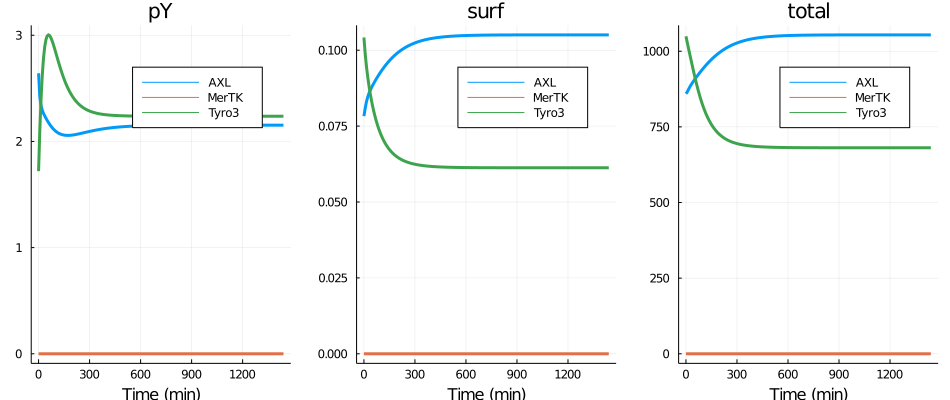

In [7]:
# plotting
using Plots
A = hcat(pYA, surfA, totalA)
M = hcat(pYM, surfM, totalM)
T = hcat(pYT, surfT, totalT)
plot(tps, [A, M, T], lw = 3, 
    xlabel = "Time (min)",
    label = ["AXL" "AXL" "AXL" "MerTK" "MerTK"  "MerTK" "Tyro3" "Tyro3" "Tyro3"], 
    title = ["pY" "surf" "total"], 
    layout = (1,3), size=(950,400))

In [8]:
# AXL knock down
A_params = vcat(samp_params[index, :], 0, MerTKexpr, Tyro3expr, Ig2rev[index], ones(4));
A_data = TAMode.runTAM(tps, A_params, 10);

A_pYA = (A_data * pYAXL) * scale[index]
A_surfA = (A_data * surfAXL) * scaleSurf[index]
A_totalA = (A_data * totAXL) 

A_pYM = (A_data * pYMerTK) * scale[index]
A_surfM = (A_data * surfMerTK) * scaleSurf[index]
A_totalM = (A_data * totMerTK) 

A_pYT = (A_data * pYTyro3) * scale[index]
A_surfT = (A_data * surfTyro3) * scaleSurf[index]
A_totalT = (A_data * totTyro3); 

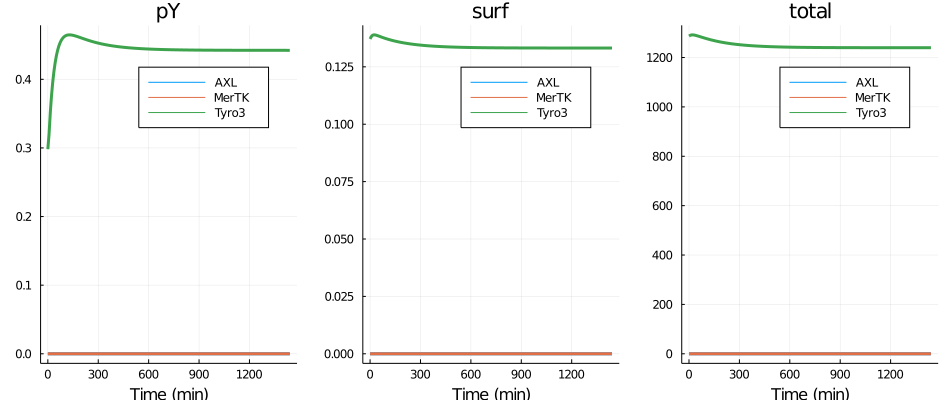

In [9]:
# plotting AXL knock down
A_A = hcat(A_pYA, A_surfA, A_totalA)
A_M = hcat(A_pYM, A_surfM, A_totalM)
A_T = hcat(A_pYT, A_surfT, A_totalT)
plot(tps, [A_A, A_M, A_T], lw = 3, 
    xlabel = "Time (min)",
    label = ["AXL" "AXL" "AXL" "MerTK" "MerTK"  "MerTK" "Tyro3" "Tyro3" "Tyro3"], 
    title = ["pY" "surf" "total"], 
    layout = (1,3), size=(950,400))

In [10]:
# Tyro 3 knock down
T_params = vcat(samp_params[index, :], AXLexpr, MerTKexpr, 0, Ig2rev[index], ones(4));
T_data = TAMode.runTAM(tps, T_params, 10);

T_pYA = (T_data * pYAXL) * scale[index]
T_surfA = (T_data * surfAXL) * scaleSurf[index]
T_totalA = (T_data * totAXL) # 4067.2585803887146

T_pYM = (T_data * pYMerTK) * scale[index]
T_surfM = (T_data * surfMerTK) * scaleSurf[index]
T_totalM = (T_data * totMerTK) # 85.86830649771866

T_pYT = (T_data * pYTyro3) * scale[index]
T_surfT = (T_data * surfTyro3) * scaleSurf[index]
T_totalT = (T_data * totTyro3); # 440.6731445966876

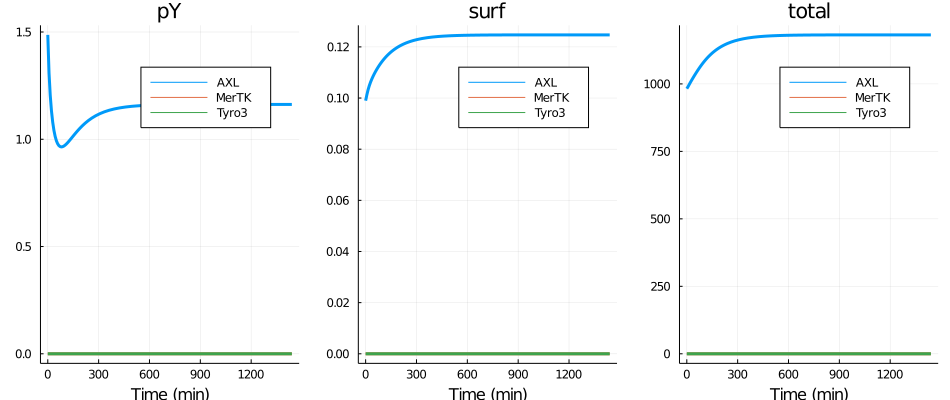

In [11]:
# plotting Tyro3 knock down
T_A = hcat(T_pYA, T_surfA, T_totalA)
T_M = hcat(T_pYM, T_surfM, T_totalM)
T_T = hcat(T_pYT, T_surfT, T_totalT)
plot(tps, [T_A, T_M, T_T], lw = 3, 
    xlabel = "Time (min)",
    label = ["AXL" "AXL" "AXL" "MerTK" "MerTK"  "MerTK" "Tyro3" "Tyro3" "Tyro3"], 
    title = ["pY" "surf" "total"], 
    layout = (1,3), size=(950,400))

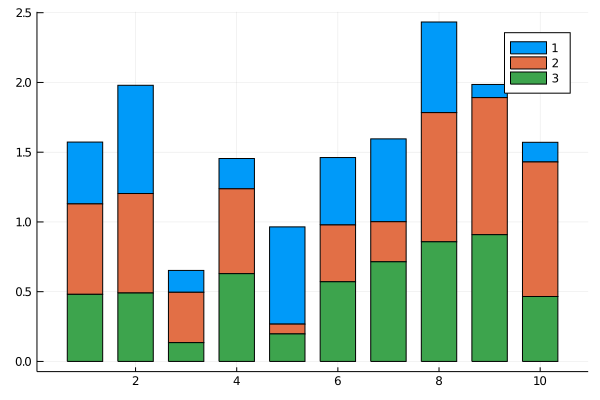

In [93]:
using StatsPlots
ctg = repeat(["1", "2", "3"], inner = 10)
groupedbar(rand(10,3), bar_position = :stack, bar_width=0.7, group = ctg)

In [20]:
using StatsPlots
function plotStackedBar(chn)
    Ig2rev = get(chn, :Ig2rev)[1]
    scale = get(chn, :scale)[1]
    scaleSurf = get(chn, :scaleSurf)[1]

    x = get(chn, [:internalize, :pYinternalize, :sortF, :kRec, :kDeg, :xFwd, :gasCur, :AXLexpr]);
    samp_params = hcat(x.internalize, x.pYinternalize, x.sortF, x.kRec, x.kDeg, x.xFwd, x.gasCur);
    
    tps = range(0.0, 1440, length=200)
    index = 201
    # M0
    AXLexpr = 6.0
    MerTKexpr = 0.0
    Tyro3expr = 5.0
    M0params = vcat(samp_params[index, :], AXLexpr, MerTKexpr, Tyro3expr, Ig2rev[index], [1.0, 1.0, 1.8, 100.0]);
    
    M0 = pYPlot(M0params, scale[index], "M0", 5)
    
#     AXLexpr = 
#     MerTKexpr = 
#     Tyro3expr = 
#     M1params = vcat(samp_params[index, :], AXLexpr, MerTKexpr, Tyro3expr, Ig2rev[index], [1.0, 1.0, 1.8, 100.0]);
    
#     M1 = pYPlot(M1params, scale[index], "M1", 10)
    
#     AXLexpr = 
#     MerTKexpr = 
#     Tyro3expr = 
#     M1params = vcat(samp_params[index, :], AXLexpr, MerTKexpr, Tyro3expr, Ig2rev[index], [1.0, 1.0, 1.8, 100.0]);
    
#     M2 = pYPlot(M1params, scale[index], "M2", 10)
    
#     plot(M0, M1, M2, layout=(1,3))
end

function pYPlot(params, scale, cellName, ylimit) 
    tps = [0.0, 480.0]
    
    pYAXL = TAMode.pY .* TAMode.recpSpecific[1]
    pYTyro3 = TAMode.pY .* TAMode.recpSpecific[3]
    
    data = TAMode.runTAM(tps, params, 10)
    pYA = (data * pYAXL) * scale # normal pYA
    pYT = (data * pYTyro3) * scale # normal pYT
    
    # AXL knockdown
    paramsAXLkd = deepcopy(params)
    paramsAXLkd[8] = 0.0
    A_data = TAMode.runTAM(tps, paramsAXLkd, 10)
    A_pYA = (A_data * pYAXL) * scale # AXLkd pYA
    A_pYT = (A_data * pYTyro3) * scale # AXLkd pYT
    
    # Tyro3 knockdown
    paramsTyrokd = deepcopy(params)
    paramsTyrokd[10] = 0.0
    T_data = TAMode.runTAM(tps, paramsTyrokd, 10)
    T_pYA = (T_data * pYAXL) * scale # Tyrokd pYA
    T_pYT = (T_data * pYTyro3) * scale # Tyrokd pYT
    
    
    
    ctg = repeat(["Phosphyrlated AXL", "Phosphorylated Tyro3"] , inner = 2)

    nam = ["0hr", "8hr", "0hr", "8hr"]

    pyAXL = vcat(pYA[1], pYA[2], A_pYA[1], A_pYA[2], T_pYA[1], T_pYA[2])
    pyTyro3 = vcat(pYT[1], pYT[2], A_pYT[1], A_pYT[2], T_pYT[1], T_pYT[2])

    y = hcat(pyAXL, pyTyro3)
    #groupedbar(nam, M0, bar_position = :stack, bar_width=0.7, bar_spacing = 0, group = ctg, title = "M0")
    normal = y[1:2,:]
    p1 = groupedbar(nam, normal, 
        bar_position = :stack, 
        group = ctg,
        legend = false,
        bar_width = 1,
        xlabel = "Normal")

    A_knockDown = y[3:4,:]
    p2 = groupedbar(nam, A_knockDown, 
        bar_position = :stack, 
        group = ctg,
        legend = false,
        yaxis = false,
        bar_width = 1,
        xlabel = "AXL Knockdown",
        title = cellName)

    T_knockDown = y[5:6,:]
    p3 = groupedbar(nam, T_knockDown, 
        bar_position = :stack, 
        group = ctg,
        yaxis = false,
        bar_width = 1,
        xlabel = "Tyro3 Knockdown")

    p = plot(p1, p2, p3, layout=(1,3), size=(700, 400))
    ylims!(0, ylimit)
    
end

pYPlot (generic function with 1 method)

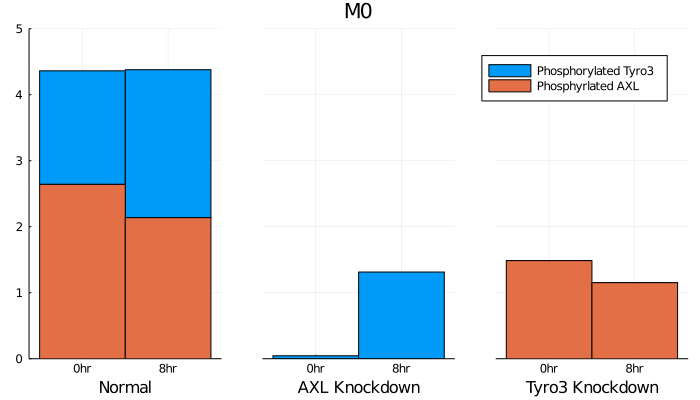

In [21]:
plotStackedBar(chn)